## Wygeneruj dataset

In [76]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cityblock
from itertools import permutations

# Generowanie danych wejściowych
np.random.seed(42)
n_orders = 4
n_trucks = 1
n_stations = 10

# Zamówienia: lokalizacja i waga
df_orders = pd.DataFrame({
    "latitude": np.random.randn(n_orders) * 50,
    "longitude": np.random.randn(n_orders) * 50,
    "mass": np.random.rand(n_orders) * 10
})

# Stacje benzynowe: lokalizacja i cena za litr
df_stations = pd.DataFrame({
    "latitude": np.random.randn(n_stations + 2) * 50,
    "longitude": np.random.randn(n_stations + 2) * 50,
    "price": np.random.rand(n_stations + 2) * 2 + 5
})

# Parametry
fuel_consumption = lambda m: m/100  # Spalanie na 100km w zależności od masy
fuel_tank_capacity = 150  # Pojemność baku
base_location = np.array([0, 0])  # Lokalizacja bazy
# average_speed = 40  # Średnia prędkość w km/h
# driver_hourly_rate = 50  # Godzinna stawka kierowcy

posx and posy should be finite values
posx and posy should be finite values


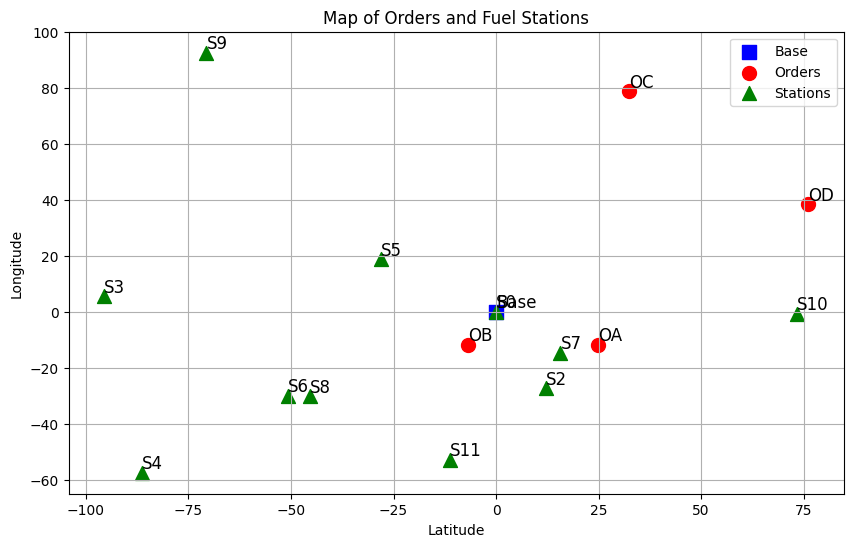

In [88]:
# Adding index as labels

# Plot orders and stations on a map
plt.figure(figsize=(10, 6))

# Plot base location
plt.scatter(base_location[0], base_location[1], c='blue', label='Base', s=100, marker='s')
plt.text(base_location[0], base_location[1], 'Base', fontsize=12, verticalalignment='bottom')

# Plot orders
plt.scatter(df_orders['latitude'], df_orders['longitude'], c='red', label='Orders', s=100, marker='o')
for i, row in df_orders.iterrows():
    plt.text(row['latitude'], row['longitude'], f'O{row.name}', fontsize=12, verticalalignment='bottom')
    
# Plot stations
plt.scatter(df_stations['latitude'], df_stations['longitude'], c='green', label='Stations', s=100, marker='^')
for i, row in df_stations.iterrows():
    plt.text(row['latitude'], row['longitude'], f'S{row.name}', fontsize=12, verticalalignment='bottom')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Map of Orders and Fuel Stations')
plt.legend()
plt.grid(True)
plt.show()


In [78]:
import string

# Generate a list of letters
letter_index = list(string.ascii_uppercase[:len(df_orders)])
df_orders.index = letter_index

# print(df_orders.loc['C'])

df_orders.head()


,latitude,longitude,mass
A,24.835708,-11.707669,0.205845
B,-6.913215,-11.706848,9.699099
C,32.384427,78.960641,8.324426
D,76.151493,38.371736,2.123391


In [79]:
df_orders.loc['A', 'longitude']


-11.707668736166799

In [80]:
df_stations.loc[0] = {'StationID': int(0), 'Latitude': float(0.0), 'Longitude': float(0.0)}
df_stations.loc[1] = {'StationID': 0, 'Latitude': 0.0, 'Longitude': 0.0}

df_stations.head()

,latitude,longitude,price
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,12.098114,-27.219136,5.517560
3,-95.664012,5.546129,6.325045
4,-86.245892,-57.549679,5.623422


## Generate starting population

In [81]:
import random
original_list = df_orders.index.tolist()
print(f"Permutacja: {original_list}")

population = []

population_size = 10

for i in range(population_size):
    sample = [0]
    random_permutation = random.sample(original_list, len(original_list))
    
    for i in range(len(random_permutation)):
        sample.append(random_permutation[i])
        
        if i != len(random_permutation)-1:
            if random.randint(0, 1) == 1:
                station_ID = random.randint(1, n_stations-1)
            else:
                station_ID = 1
    
            sample.append(station_ID)
    # print(sample)
    sample.append(0)
    population.append(sample)
    
for i in population:
    print(i)

Permutacja: ['A', 'B', 'C', 'D']
[0, 'A', 1, 'B', 1, 'C', 9, 'D', 0]
[0, 'C', 1, 'B', 1, 'D', 7, 'A', 0]
[0, 'A', 5, 'B', 1, 'C', 6, 'D', 0]
[0, 'A', 5, 'B', 1, 'C', 1, 'D', 0]
[0, 'A', 1, 'D', 3, 'B', 6, 'C', 0]
[0, 'D', 6, 'A', 7, 'C', 1, 'B', 0]
[0, 'C', 1, 'D', 1, 'B', 1, 'A', 0]
[0, 'B', 6, 'C', 7, 'D', 1, 'A', 0]
[0, 'C', 7, 'B', 9, 'D', 4, 'A', 0]
[0, 'D', 1, 'A', 1, 'C', 8, 'B', 0]


In [82]:
# # Mini przykład
# a = 3
# b = 'A'
# current_mass = 1

def evaluate_step(a, b, current_mass, fuel_level):

    fuel_penalty = 1000
    max_fuel = 150

    
    step_cost = 0
    
    # miasto - miasto
    if isinstance(a, str) & isinstance(b, str):
        # print("z miasta do miasta - bez stacji")
        
        distance = (abs(df_orders.loc[a, 'longitude'] - df_orders.loc[b, 'longitude']) + 
                    abs(df_orders.loc[a, 'latitude'] - df_orders.loc[b, 'latitude']))

        fuel_level = fuel_level - distance * fuel_consumption(current_mass)
        
        # print("fuel_level: ", fuel_level)
        
        if fuel_level < 0:
            step_cost += fuel_penalty
            print("LAWECIARZ NA MIEJSCU")
            
        current_mass += df_orders.loc[b, 'mass']
        # print(f"Załadowano {df_orders.loc[b, 'mass']} towaru. {current_mass} mamy razem na pace")
        
    elif isinstance(a, str):

        if b != 1:
            if b == 0:
                df_stations.loc[b, 'latitude'] = float(0)
                df_stations.loc[b, 'longitude'] = float(0)
                df_stations.loc[b, 'price'] = np.random.rand() * 2 + 5
    
            # print("z miasta na stację - dojeżdżam na stację")    

    
            distance = (abs(df_orders.loc[a, 'longitude'] - df_stations.loc[b, 'longitude']) + 
                        abs(df_orders.loc[a, 'latitude'] - df_stations.loc[b, 'latitude']))
            # print('distance: ', distance)
    
            fuel_level = fuel_level - distance * fuel_consumption(current_mass)
    
            # print("fuel_level: ", fuel_level)
    
            if fuel_level < 0:
                step_cost += fuel_penalty
                print("LAWECIARZ NA MIEJSCU")
    
            step_cost += df_stations.loc[b, 'price'] * (max_fuel - fuel_level)
    
            # print(f"Zatankowano {(max_fuel - fuel_level)} litrów za {df_stations.loc[b, 'price'] * (max_fuel - fuel_level)} złotych" )
    
            fuel_level = max_fuel
        
    else:
        # print("ze stacji do miasta")
        
        if a == 0:
            df_stations.loc[a, 'latitude'] = float(0)
            df_stations.loc[a, 'longitude'] = float(0)
        
        distance = (abs(df_stations.loc[a, 'longitude'] - df_orders.loc[b, 'longitude']) + 
                    abs(df_stations.loc[a, 'latitude'] - df_orders.loc[b, 'latitude']))

        fuel_level = fuel_level - distance * fuel_consumption(current_mass)
        
        # print("fuel_level: ", fuel_level)
        
        if fuel_level < 0:
            step_cost += fuel_penalty
            # print("LAWECIARZ NA MIEJSCU")
            
        current_mass += df_orders.loc[b, 'mass']
        # print(f"Załadowano {df_orders.loc[b, 'mass']} towaru. {current_mass} mamy razem na pace")

    return current_mass, fuel_level, step_cost

# evaluate_step(a, b, current_mass, 150)

In [83]:
# sample = [0, 'A', 1, 'B', 1, 'C', 0]


def evaluate_case(sample):
    total_cost = 0
    fuel_level = 150
    current_mass = 1
    
    # print(f"START FUEL: {fuel_level}")
    for i in range(len(sample)-1):
        
        if sample[i] == 1:
            current_mass, fuel_level, step_cost = evaluate_step(sample[i-1], sample[i+1], current_mass, fuel_level)
        else:
            current_mass, fuel_level, step_cost = evaluate_step(sample[i], sample[i+1], current_mass, fuel_level)
        
        total_cost += step_cost
        # print(f"total cost: {total_cost}")
    
    
    return total_cost
    
# evaluate_case(sample)

In [84]:
for sample in population:
    print(f"{sample} results: {evaluate_case(sample)}")

[0, 'A', 1, 'B', 1, 'C', 9, 'D', 0] results: 635.6648683631463
[0, 'C', 1, 'B', 1, 'D', 7, 'A', 0] results: 406.5917959462088
[0, 'A', 5, 'B', 1, 'C', 6, 'D', 0] results: 644.3519782055096
[0, 'A', 5, 'B', 1, 'C', 1, 'D', 0] results: 307.3822671168054
[0, 'A', 1, 'D', 3, 'B', 6, 'C', 0] results: 372.2778722962468
[0, 'D', 6, 'A', 7, 'C', 1, 'B', 0] results: 190.79006920659646
[0, 'C', 1, 'D', 1, 'B', 1, 'A', 0] results: 223.80474237102675
[0, 'B', 6, 'C', 7, 'D', 1, 'A', 0] results: 546.1565929572243
[0, 'C', 7, 'B', 9, 'D', 4, 'A', 0] results: 1081.2075984004578
[0, 'D', 1, 'A', 1, 'C', 8, 'B', 0] results: 264.2778148672866
